External file: UPENN-GBM-00022_11_T1.nii.gz
Predicted label: Tumor
Averaged softmax probs: [8.0477155e-05 9.9991947e-01]
Saved visualization → perfect_axial_view.png


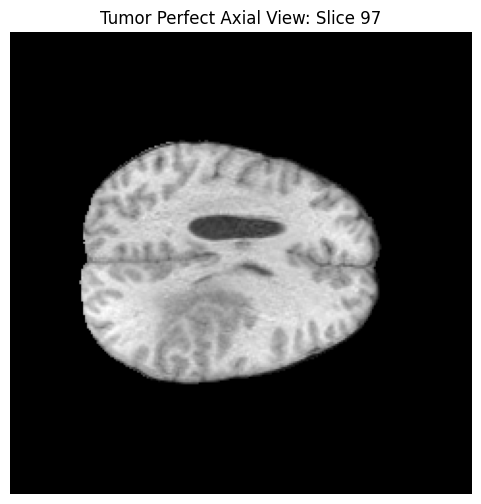

In [ ]:
#!/usr/bin/env python3
import os
import nibabel as nib
import numpy as np
import torch
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# -------------------------
# Helper functions
# -------------------------

def load_volume_in_axial(file_path):
    """Load a NIfTI, reorient to canonical RAS, return a 3D numpy array."""
    img = nib.load(file_path)
    img = nib.as_closest_canonical(img)
    data = img.get_fdata()
    if data.ndim == 4:
        data = data[..., 0]
    return data

def safe_normalize(slice_img):
    """Linearly scale a 2D slice to [0,255] uint8 (handles flat slices)."""
    mn, mx = slice_img.min(), slice_img.max()
    if mx - mn < 1e-8:
        return np.zeros_like(slice_img, dtype=np.uint8)
    norm = (slice_img - mn) / (mx - mn) * 255
    return norm.astype(np.uint8)

def infer_volume(model, file_path, before=5, after=40, transform=None, device='cpu'):
    """
    Run slice-wise inference on the axial stack:
      - take slices [mid-before : mid+after]
      - apply transform or basic ToTensor()
      - softmax and collect probs
    Returns: (pred_class, mean_prob_vector)
    """
    model.eval()
    volume = load_volume_in_axial(file_path)
    num_slices = volume.shape[2]
    mid = num_slices // 2
    lb = max(0, mid - before)
    ub = min(num_slices - 1, mid + after)

    softmax = nn.Softmax(dim=1)
    all_probs = []

    for idx in range(lb, ub+1):
        sl = volume[:, :, idx]
        sl8 = safe_normalize(sl)
        pil = Image.fromarray(sl8).convert('L')

        if transform is not None:
            inp = transform(pil).unsqueeze(0)
        else:
            inp = transforms.ToTensor()(pil).unsqueeze(0)

        inp = inp.to(device)
        with torch.no_grad():
            logits = model(inp)
            probs = softmax(logits)
        all_probs.append(probs.cpu().numpy()[0])

    all_probs = np.stack(all_probs, axis=0)                # (num_slices, num_classes)
    mean_prob = all_probs.mean(axis=0)                     # (num_classes,)
    final_pred = int(mean_prob.argmax())
    return final_pred, mean_prob

def visualize_external_volume(file_path, predicted_label, threshold_factor=0.1):
    """
    Pick and plot the ‘perfect axial view’:
      - if Tumor: slice with highest sum intensity
      - if Non-Tumor: slice with largest brain area (>threshold)
    Returns: the Matplotlib Figure.
    """
    volume = load_volume_in_axial(file_path)
    num_slices = volume.shape[2]

    if predicted_label == 1:
        # tumor → pick highest total intensity
        sums = [volume[:, :, i].sum() for i in range(num_slices)]
        chosen = int(np.argmax(sums))
        label_str = "Tumor"
    else:
        # non-tumor → pick largest area above threshold
        global_max = volume.max()
        thr = threshold_factor * global_max
        best_area, chosen = 0, 0
        for i in range(num_slices):
            mask = (volume[:, :, i] >= thr).astype(np.uint8)
            area = mask.sum()
            if area > best_area:
                best_area, chosen = area, i
        label_str = "Non-Tumor"

    sl = volume[:, :, chosen]
    sl8 = safe_normalize(sl)

    fig = plt.figure(figsize=(6,6))
    plt.imshow(sl8, cmap='gray', origin='lower')
    plt.title(f"{label_str} Perfect Axial View: Slice {chosen}")
    plt.axis('off')
    return fig

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    # 1) device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 2) rebuild model architecture
    model = timm.create_model('efficientnet_b0', pretrained=False, in_chans=1)
    numf = model.classifier.in_features
    model.classifier = nn.Linear(numf, 2)
    model.to(device)

    # 3) load weights
    ckpt = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\web\backend\final_tumor_recognition_model_script.pt"
    model = torch.jit.load(ckpt, map_location=device)
    model.to(device).eval()

    # 4) define transforms (must match training)
    slice_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # 5) point to external file
    external_file = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\UPenn_GBM\images\UPENN-GBM-00022_11\UPENN-GBM-00022_11_T1.nii.gz"

    # 6) run inference
    pred_lbl, pred_prob = infer_volume(
        model,
        external_file,
        before=5,
        after=40,
        transform=slice_transform,
        device=device
    )
    lbl_str = "Tumor" if pred_lbl == 1 else "Non-Tumor"
    print(f"External file: {os.path.basename(external_file)}")
    print(f"Predicted label: {lbl_str}")
    print(f"Averaged softmax probs: {pred_prob}")

    # 7) visualize & save
    fig = visualize_external_volume(external_file, predicted_label=pred_lbl, threshold_factor=0.1)
    out_png = "perfect_axial_view.png"
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    print(f"Saved visualization → {out_png}")